In [2]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/sounds.zip" -d "/content"

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys
import tensorflow as tf

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio

import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore"
                         )
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
data = '/content/sounds'

dir_list = os.listdir(data)
dir_list.sort()

emotion = []
path = []
for i in dir_list:
    sub_dir_path = os.path.join(data, i)
    if os.path.isdir(sub_dir_path):
        fname = os.listdir(sub_dir_path)
        for f in fname:
            if f.endswith('.wav'):
                part = f.split('.')[0].split('_')
                file_path = os.path.join(sub_dir_path, f)
                path.append(file_path)


In [6]:
def text_num_split(item):
    for index, letter in enumerate(item, 0):
        if letter.isdigit():
            return [item[:index],item[index:]]

In [8]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [ ]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate, color = 'b')
Audio(x, rate=sample_rate)

In [14]:
def feat_ext(data):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return mfcc

def get_feat(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # normal data
    res1 = feat_ext(data)
    result = np.array(res1)
    #data with noise
    noise_data = noise(data)
    res2 = feat_ext(noise_data)
    result = np.vstack((result, res2))
    #data with stretch and pitch
    new_data = librosa.effects.time_stretch(data, rate=2.0)
    data_stretch_pitch = librosa.effects.pitch_shift(new_data, sr=sample_rate, n_steps=4)
    res3 = feat_ext(data_stretch_pitch)
    result = np.vstack((result, res3))
    return result

In [20]:
pip install git+https://github.com/openai/whisper.git

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-lr0rilu1
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-lr0rilu1
  Resolved https://github.com/openai/whisper.git to commit ba3f3cd54b0e5b8ce1ab3de13e32122d0d5f98ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.1 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20231117-py3-none-any.whl size=802825 sha256=040c777fba5407b35d0ba3261a90035ce4bca93215894c9af42aef6626154580
  Stored in directory: /tmp/pip-ephem-wheel-cache-hrwiv0ks/wheels/8b/6c/d0/622666868c179f156cf595c8b6f06f88bc5d80c4b31dccaa03
Successfully built openai-whisper
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dep

In [3]:
from IPython.display import Audio
Audio('/content/sounds/Trafic/trafic-26.wav')


In [2]:
import whisper

model = whisper.load_model("large-v3")

In [3]:
model.device

device(type='cuda', index=0)

In [5]:
model = model.to('cpu')


In [6]:
import whisper
from transformers import pipeline

# Load and preprocess the audio
audio = whisper.load_audio('/content/sounds/Trafic/trafic-26.wav')
audio = whisper.pad_or_trim(audio)

# Compute the log-Mel spectrogram
mel = whisper.log_mel_spectrogram(audio=audio, n_mels=128)

# Detect the spoken language
_, probs = model.detect_language(mel)
detected_language = max(probs, key=probs.get)

# Decode the audio
options = whisper.DecodingOptions(fp16=False)
result = whisper.decode(model, mel, options)

# Initialize the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define the sequence to classify
sequence_to_classify = result.text

# Define the candidate labels
candidate_labels = ['شرطة', 'دفاع مدني', 'الاسعاف', 'المرور']

# Use the classifier to perform zero-shot classification
classification = classifier(sequence_to_classify, candidate_labels, multi_label=False)

# Get the direct label for the highest-scoring class
predicted_label = classification['labels'][0]

# Print the detected language and predicted label
print(f"Detected language: {detected_language}")
print(f"Predicted label: {predicted_label}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Detected language: ar
Predicted label: شرطة


In [5]:
# load audio and pad/trim it to fit 30 seconds
audio = whisper.load_audio('/content/sounds/Trafic/trafic-26.wav')
audio = whisper.pad_or_trim(audio)

# make log-Mel spectrogram and move to the same device as the model
mel = whisper.log_mel_spectrogram(audio=audio, n_mels=128)


# detect the spoken language
_, probs = model.detect_language(mel)
print(f"Detected language: {max(probs, key=probs.get)}")

# decode the audio
options = whisper.DecodingOptions(fp16 = False)

result = whisper.decode(model, mel, options)

# print the recognized text
print(result.text)

Detected language: ar
السلام عليكم في حادث سير خمس سيارات على طريق الملك سلمان باتجاه المطار في وجود اصابات


In [6]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
# Define the sequence you want to classify
sequence_to_classify = result.text   #"في مضاربة عند المدرسة في ثانوية الأمير بندر في واحد طاعل طالب بصراحة رسل الشرطة"

# Define the candidate labels
candidate_labels = ['شرطة', 'دفاع مدني', 'الاسعاف', 'المرور']

# Load the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification")

# Use the classifier to perform zero-shot classification
classification = classifier(sequence_to_classify, candidate_labels, multi_label=False)

# Get the direct label for the highest-scoring class
predicted_label = classification['labels'][0]

# Print the predicted label
print(predicted_label)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


شرطة


In [8]:
import whisper
print(whisper.__version__)

20231117


In [ ]:
from whisper import SequenceClassifier

# Create an instance of the SequenceClassifier
classifier = SequenceClassifier()

# Define the sequence you want to classify
sequence_to_classify = "طلق نار أمامي الآن طلق نار"

# Define the candidate labels
candidate_labels = ['شرطة', 'دفاع مدني', 'الاسعاف', 'مرور الطرق']

# Use the classifier to classify the sequence
classification = classifier(sequence_to_classify, candidate_labels)

# Print the classification results
print(classification)

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

In [ ]:
model = Sequential()
model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(LSTM(256, return_sequences=True))

model.add(LSTM(128))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax'))

optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 2048)          12288     
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 2048)          0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 10, 2048)          8192      
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 1024)          10486784  
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 5, 1024)           0         
 g1D)                                                            
                                                        

In [ ]:
history = model.fit(x_traincnn, y_train, batch_size=64, epochs=100, validation_data=(x_testcnn, y_test))

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

8/8 [==============================] - 72s 8s/step - loss: 1.4064 - accuracy: 0.2598
Accuracy of our model on test data :  25.984251499176025 %


ValueError: x and y must have same first dimension, but have shapes (1500,) and (100,)

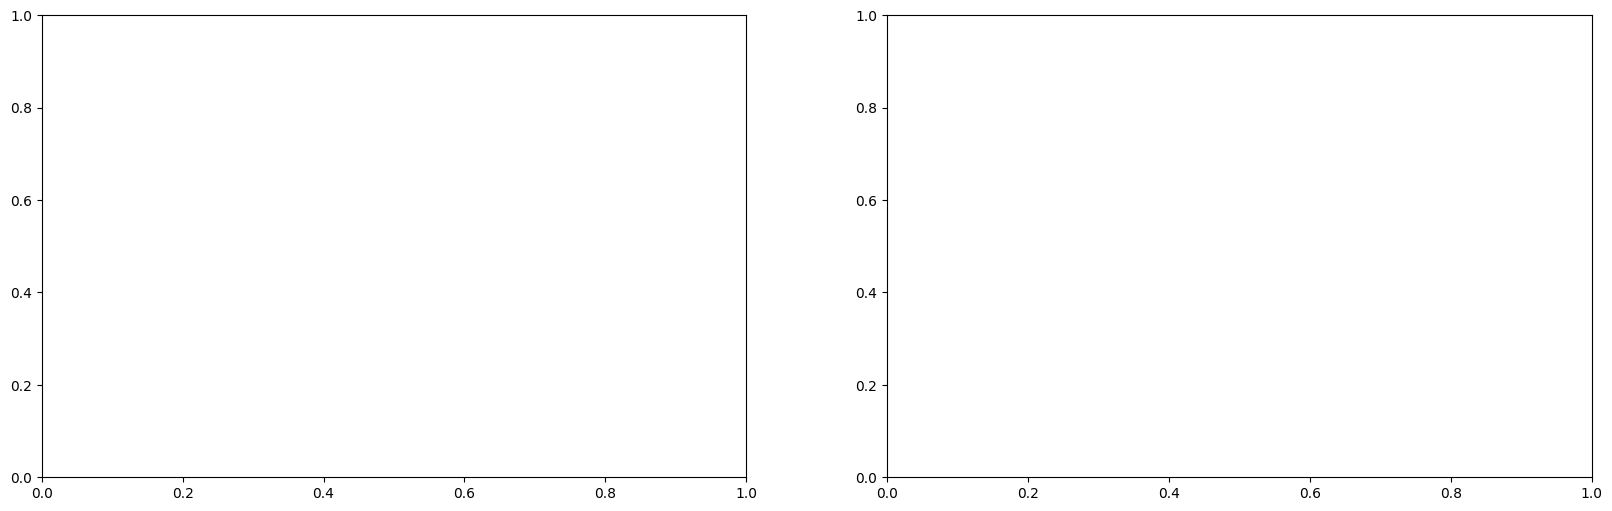

In [ ]:
epochs = [i for i in range(1500)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
pred_test = model.predict(x_testcnn)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(100)

8/8 [==============================] - 4s 97ms/step


,Predicted Labels,Actual Labels
0,angry,angry
1,drunk,drunk
2,angry,angry
3,angry,angry
4,painful,painful
...,...,...
95,drunk,painful
96,angry,painful
97,painful,drunk
98,stressful,stressful


In [ ]:
model_name = 'Emotion_Emergency.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved trained model at /content/saved_models/Emotion_Emergency.h5 


In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/saved_models/Emotion_Emergency.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
## data, sampling_rate = librosa.load('../input/dataset-ec/RAW_DATA/NOT_STRESSFUL/not_stressful61.wav')

In [ ]:
sample = "/content/CUSTOM_DATASET/Speaker10/03_01_00_02_10.wav"
feature = get_feat(sample)
test =np.expand_dims(feature, axis=2)
livepreds = loaded_model.predict(test)
livepredictions = (encoder.inverse_transform((livepreds)))
livepredictions

1/1 [==============================] - 2s 2s/step


array([['drunk'],
       ['stressful'],
       ['drunk']], dtype=object)

In [ ]:


whisper_model =  whisper.load_model("large-v3")


whisper_model.layers.pop()


whisper_model.add(Dense(4, activation='softmax'))


for layer in whisper_model.layers[:-1]:
    layer.trainable = False


whisper_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

whisper_model.fit(x_train_source, y_train_source, validation_data=(x_val_source, y_val_source), epochs=10, batch_size=32)


val_loss, val_acc = whisper_model.evaluate(x_val_source, y_val_source)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)


transfer_model = Model(inputs=whisper_model.input, outputs=whisper_model.layers[-2].output)

transfer_model.add(Dense(4, activation='softmax'))

transfer_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
transfer_model.fit(x_train_target, y_train_target, validation_data=(x_val_target, y_val_target), epochs=10, batch_size=32)


target_loss, target_acc = transfer_model.evaluate(x_val_target, y_val_target)
print("Target domain loss:", target_loss)
print("Target domain accuracy:", target_acc)